In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))

from PySDM.physics import si
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity
from PySDM.initialisation.spectra import Gaussian
from PySDM.physics.formulae import volume

/home/edejong/.conda/envs/edjPySDM/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


# TODO: Work from here down has not been updated from const kern

# 1. Golovin Kernel

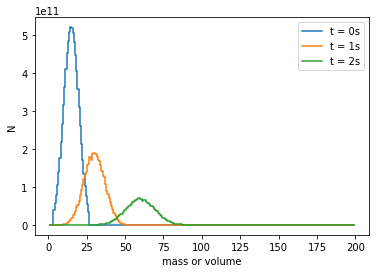

In [18]:
n_sd = 2**17
initial_spectrum = Gaussian(norm_factor=8.39e12, loc=15 * si.um**3, scale=5 * si.um**3)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KthMoment

golovin_const = 1e4 / si.um**3 / si.s

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=1 * si.s, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = golovin_const)))
products = [ParticlesNumberVolumeSpectrum(), KthMoment()]
particles = builder.build(attributes, products)

from PySDM.physics.constants import rho_w
from matplotlib import pyplot
import numpy as np

v_bins_edges = np.linspace((1 * si.um**3), (200 * si.um**3), num=256)

for step in [0, 1, 2]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1] / si.um**3,
                y=particles.products['N(v)'].get(v_bins_edges),
                where='post', label=f"t = {step}s")
                
#pyplot.xscale('log')
pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()

kernel const / dv * characteristic volume * dt =

(1e4 / um^3 / sec) / (1) * (15 um^3) * 1 sec = 150,000

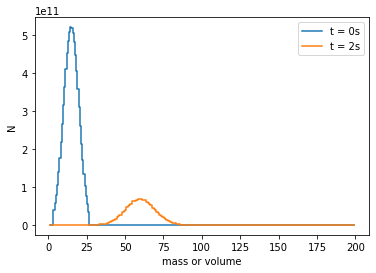

In [17]:
n_sd = 2**17
initial_spectrum = Gaussian(norm_factor=8.39e12, loc=15 * si.um**3, scale=5 * si.um**3)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KthMoment

golovin_const = 5e3 / si.um**3 / si.s

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=1 * si.s, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = golovin_const)))
products = [ParticlesNumberVolumeSpectrum(), KthMoment()]
particles = builder.build(attributes, products)

from PySDM.physics.constants import rho_w
from matplotlib import pyplot
import numpy as np

v_bins_edges = np.linspace((1 * si.um**3), (200 * si.um**3), num=256)

for step in [0, 2]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1] / si.um**3,
                y=particles.products['N(v)'].get(v_bins_edges),
                where='post', label=f"t = {step}s")
                
#pyplot.xscale('log')
pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()

## Converting back to a function via Gaussian KDE
Note that it seems that the scipy KDE function fails when n_sd > 2^11, possibly due to some maximum number of values it allows for the kde to be built. Tends to look bimodal when this is the input.

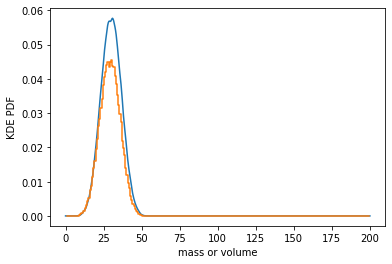

In [24]:
from scipy import stats

## Interpolate it back to a smooth function
final_counts = particles.products['N(v)'].get(v_bins_edges)
n_drop_final = int(particles.products['Mk'].get(0))

kde_pts = particles.particles.get_extensive_attrs().to_ndarray() / si.um**3
kde = stats.gaussian_kde(kde_pts[0])

x = np.linspace(0,200,500)
y = kde(x)
pyplot.plot(x ,y)
pyplot.xlabel("mass or volume")
pyplot.ylabel("KDE PDF")
pyplot.step(v_bins_edges[:-1] / si.um**3, particles.products['N(v)'].get(v_bins_edges)/n_drop_final)

## Distribution comparison:
We have 
- kde(x), the superdroplets
- rbf(x), the collocation method
- mom(x), the original Cloudy MOM

In [25]:
# import rbf from julia setup
from scipy.stats import norm

def gauss_basis(x, mean, stddev):
    return norm.pdf(x, loc=mean, scale=stddev)

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*gauss_basis(x, means[i], stddev[i])
        
    return pdf_result

def rbf3(x):
    means = [15.0, 38.72983346207418, 100.00000000000004]
    stddev = [14.831145913796364, 38.29385408620366, 38.29385408620366]
    c =  [-2.0807092242692423e-9, 0.6053386794806238, 0.39466132260008535]
    return rbf_basis(x, c, means, stddev)

def rbf6(x):
    means =  [15.0, 21.921638274328885, 32.03721497536807, 46.82054920046206, 68.42554289186319, 100.00000000000004]
    stddev = [5.0, 6.322235438149493, 9.239583890683742, 13.503121057125703, 19.734035692585532, 19.734035692585532]
    c =  [0.05340701174070742, 0.007571670167403112, 0.09425153571627659, 0.19507673114462015, -1.9055478471156834e-8, 0.6496930702864712]
    return rbf_basis(x, c, means, stddev)
    
def rbf10(x):
    means =  [15.0, 18.51981630688223, 22.865573069377408, 28.231080866430858, 34.85562878606914, 43.034656158591815, 53.13292845913057, 65.60080499398758, 80.99432387148349, 100.00000000000004]
    stddev = [5.0, 2.716097976559486, 3.353442373158406, 4.140342449773926, 5.111892107826672, 6.31142018783672, 7.792422834285633, 9.620949298434942, 11.878547580322847, 11.878547580322847]
    c =  [0.06526275826039045, 0.004482566296582142, 0.027123490214170196, 0.03949229841248938, 0.04426841061653683, 0.06726775739557111, 0.046121814131719154, 0.17068940022476922, -2.294022732177068e-7, 0.5352917338500447]
    return rbf_basis(x, c, means, stddev)
    

In [26]:
# import cloudy from julia setup
def mom(x):
    mean = 90.03
    stddev = 83.07
    return norm.pdf(x, loc=mean, scale=stddev)


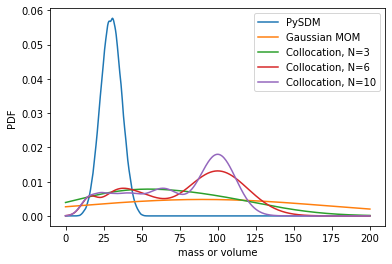

In [27]:
# plot all of them
x = np.linspace(0,200,500)
ykde = kde(x)
pyplot.plot(x ,ykde, label="PySDM")
ymom = mom(x)
pyplot.plot(x, ymom, label="Gaussian MOM")
yrbf3 = rbf3(x)
pyplot.plot(x, yrbf3, label="Collocation, N=3")
yrbf6 = rbf6(x)
pyplot.plot(x, yrbf6, label="Collocation, N=6")
yrbf10 = rbf10(x)
pyplot.plot(x, yrbf10, label="Collocation, N=10")

pyplot.xlabel("mass or volume")
pyplot.ylabel("PDF")
pyplot.legend()

In [21]:
# KL Divergence of 2 metrics
from scipy.stats import entropy

def kl_div(qk, pk):
    return entropy(qk, pk)

print("PySDM: ", kl_div(ykde, ykde))
print("MOM: ", kl_div(ykde, ymom))
print("RBF3: ", kl_div(ykde, yrbf3))
print("RBF6: ", kl_div(ykde, yrbf6))
print("RBF10: ", kl_div(ykde, yrbf10))

PySDM:  0.0
MOM:  2.029172552233636
RBF3:  1.5717934999168013
RBF6:  1.69163162717646
RBF10:  1.7090767083981127


In [24]:
# KS test

def ks_test(qk, pk):
    dists = abs(qk - pk)
    return max(dists)

print("PySDM: ", ks_test(ykde, ykde))
print("MOM: ", ks_test(ykde, ymom))
print("RBF3: ", ks_test(ykde, yrbf3))
print("RBF6: ", ks_test(ykde, yrbf6))
print("RBF10: ", ks_test(ykde, yrbf10))

PySDM:  0.0
MOM:  0.055917219679108246
RBF3:  0.05269681954121587
RBF6:  0.052701217250456366
RBF10:  0.0530099598292539


In [27]:
# W1 distance (empirical)
from scipy.stats import wasserstein_distance

def w1(qk, pk):
    return wasserstein_distance(qk, pk)

print("PySDM: ", w1(ykde, ykde))
print("MOM: ", w1(ykde, ymom))
print("RBF3: ", w1(ykde, yrbf3))
print("RBF6: ", w1(ykde, yrbf6))
print("RBF10: ", w1(ykde, yrbf10))

PySDM:  0.0
MOM:  0.0071825171801885405
RBF3:  0.007007087038488829
RBF6:  0.00631502397973223
RBF10:  0.005589653642965478


## Ouputting Moments
Either the k'th or the first k moments can be output with my defined state products.

In [28]:
# Save and print the moments, for example
from PySDM.products.state import KthMoment

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=1 * si.s, dv=1e6 * si.m**3))
builder.add_dynamic(Coalescence(kernel=ConstKern(kernel_const = 0.005 / si.s)))
products = [KthMoment()]
particles = builder.build(attributes, products)

k = 0
for step in [0, 1, 2]:
    particles.run(step - particles.n_steps)
    print(particles.products['Mk'].get(k))

NameError: name 'ConstKern' is not defined

[[8.22220004e+12 1.23333001e-04 2.02954011e-21]
 [4.11110002e+12 1.23333001e-04 3.87900129e-21]]
[[1.         1.         1.        ]
 [0.5        1.         1.91127107]]


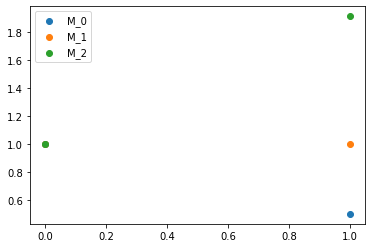

In [24]:
# Plot the moments over time
n_time = 2
from PySDM.products.state import KMoments

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=1 * si.s, dv=1e6 * si.m**3))
builder.add_dynamic(Coalescence(kernel=ConstKern(kernel_const = 0.01/(n_time-1) / si.s)))
products = [KMoments()]
particles = builder.build(attributes, products)

k = 3
tsteps = range(n_time)
Mk = np.zeros((len(tsteps), k))
Mk_norm = np.zeros((len(tsteps), k))


for i, step in enumerate(tsteps):
    particles.run(step - particles.n_steps)
    Mk[i,:] = (particles.products['M0-Mk'].get(k))
    Mk_norm[i,:] = Mk[i,:] / Mk[0,:]
print(Mk)
print(Mk_norm) 

for j in range(k):
    pyplot.scatter([t/(n_time-1) for t in tsteps], Mk_norm[:,j], label=f"M_{j}")
    
pyplot.legend()